In [1]:
from src.load_data import load_sleep_data
import matplotlib.pyplot as plt
import numpy as np
from ZilongCode.utils import get_theta2alpha_ratio, find_sleep_intervals, find_REM_interval, find_SIA_intervals, find_ones_intervals
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import matplotlib.gridspec as gridspec
from ZilongCode.utils import detect_sleep_periods

In [4]:
#load data
epoch_key = ('bon', 8, 3)
brain_areas = ['CA1', 'CA2', 'CA3']
exclude_interneuron_spikes = True
data = load_sleep_data(epoch_key, brain_areas=brain_areas, exclude_interneuron_spikes=exclude_interneuron_spikes)

Get candidate sleep periods by thresholding speed...
Get REM sleep periods from all CA1 tetrodes signal by thresholding theta/alpha ratio...
Get SIA periods from aggregated LFP signal by thresholding LFP amplitude...
Get nonREM periods from low speed periods and REM periods...
Get LIA periods from low speed periods, REM periods and SIA periods...
Get the final sleep periods from nonREM periods and LIA periods...
Plot the results...
Get the sleep information and save it...


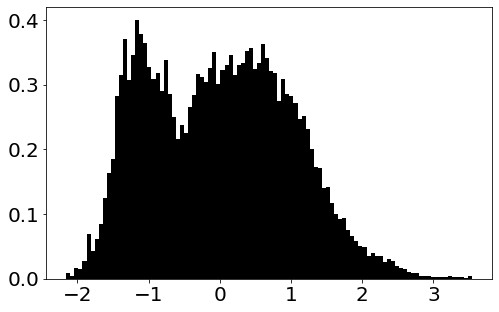

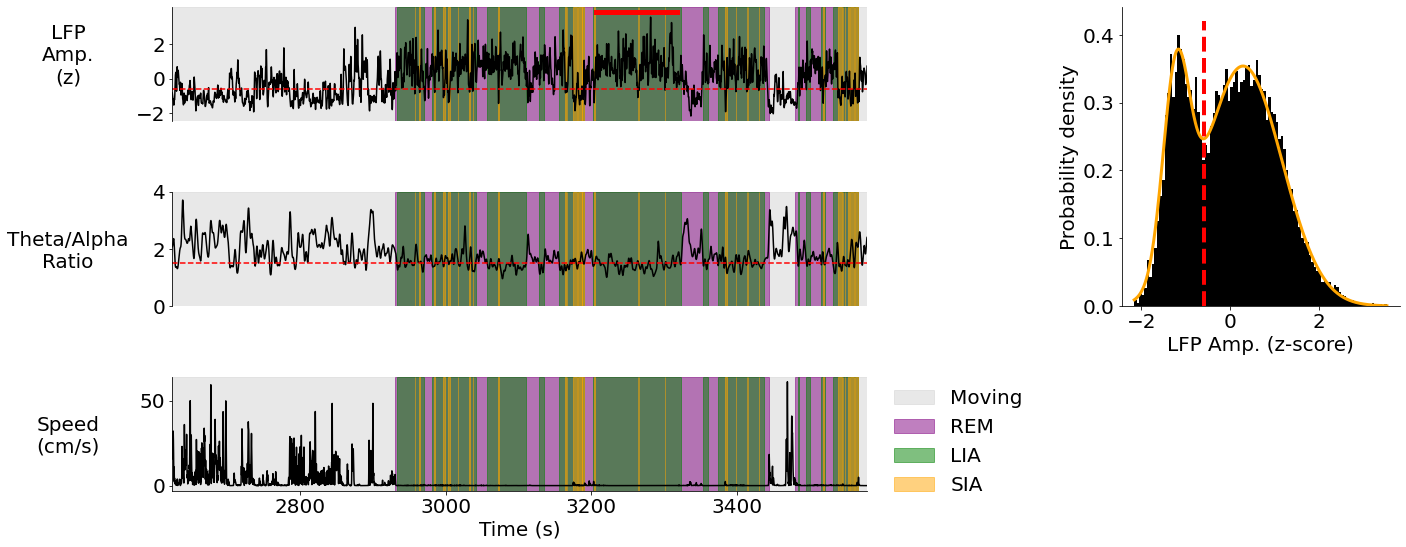

: 

In [5]:
figdir = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/sleepperiod_figures'
is_sleep_flags, sleep_intervals, sleep_durations = detect_sleep_periods(data, epoch_key, 
                                                        lowspeed_thres=4, lowspeed_duration=60,
                                                        theta2alpha_thres=1.5, REM_duration=10,
                                                        sleep_duration=90, LIA_duration=5,
                                                        plot=True, figdir=figdir)

### 1, get candidate sleep periods with speed < 4 cm/s, preceded by 60 s with no movement > 4 cm/s.  

In [3]:
#get candidate sleep periods with speed < 4 cm/s, preceded by 60 s with no movement > 4 cm/s.  
speed = data['position_info'].speed
is_lowspeed, lowspeed_durations, lowspeed_intervals = find_sleep_intervals(speed, sleep_duration_threshold=60, lowspeed_threshold=4)

### 2, get the REM sleep periods with the averaged the theta/alpha ratio using only CA1 tetrodes

In [4]:
lfps = data['lfps']
REMthreshold = 1.5 
REMduration = 10 

tetrode_info = data['tetrode_info']
CA1_areas = ['CA1']
is_CA1_areas = (
    tetrode_info.area.astype(str).str.upper().isin(CA1_areas))

#find lfps in CA1 according to is_brain_areas
CA1_lfps = lfps.loc[:, is_CA1_areas.values]

#initial a panda dataframe to store the theta/alpha ratio for each interval
all_theta2alpha_ratio = pd.DataFrame(index=CA1_lfps.index)
#for each column in CA1_lfps, get the theta/alpha ratio
for i in range(CA1_lfps.shape[1]):
    CA1_lfp = CA1_lfps.iloc[:, i]

    #initial a panda dataframe to store the theta/alpha ratio for each interval
    ratio = pd.DataFrame(index=CA1_lfp.index)

    #get the theta/alpha ratio
    theta2alpha_ratio = get_theta2alpha_ratio(CA1_lfp, thetaband=[5,11], alphaband=[1,4])
    
    #add the ratio to the theta2alpha_ratio to i column in all_theta2alpha_ratio
    all_theta2alpha_ratio[i] = theta2alpha_ratio
    
#get the mean ratio across all columns for each time point
mean_theta2alpha_ratio = all_theta2alpha_ratio.mean(axis=1)

#get the REM intervals
is_REM, REM_durations, REM_intervals  = find_REM_interval(mean_theta2alpha_ratio, REMduration=REMduration, REMthreshold=REMthreshold)    


### 3, get the aggregated hippocampal LFP using CA1 CA2 and CA3 tetrodes

In [5]:
lfps = data['lfps']
tetrode_info = data['tetrode_info']
CA123_areas = ['CA1', 'CA2', 'CA3']
is_brain_areas = (
    tetrode_info.area.astype(str).str.upper().isin(CA123_areas))

#find lfps in CA1 according to is_brain_areas
CA123_lfps = lfps.loc[:, is_brain_areas.values]

#processing the lfps
for i in range(CA123_lfps.shape[1]):
    #square the lfp signal
    CA123_lfps.iloc[:, i] = CA123_lfps.iloc[:, i]**2
    #Gaussian smooth the lfp signal with sigma=150, i.e. 300 ms since sampling rate is 500 Hz
    CA123_lfps.iloc[:, i] = gaussian_filter(CA123_lfps.iloc[:, i], sigma=150)
    #take square root of the lfp signal
    CA123_lfps.iloc[:, i] = np.sqrt(CA123_lfps.iloc[:, i])
    #z-score the lfp signal
    CA123_lfps.iloc[:, i] = (CA123_lfps.iloc[:, i] - CA123_lfps.iloc[:, i].mean())/CA123_lfps.iloc[:, i].std()

#sum the lfp over all columns
CA123_lfps_sum = CA123_lfps.sum(axis=1)
#z-score the sum lfp to get the aggregate hippocampal LFP signal
aggregate_hpc_lfp = (CA123_lfps_sum - CA123_lfps_sum.mean())/CA123_lfps_sum.std()

### 4, get the SIA threshod and find LIA periods

Text(0, 0.5, 'Probability density')

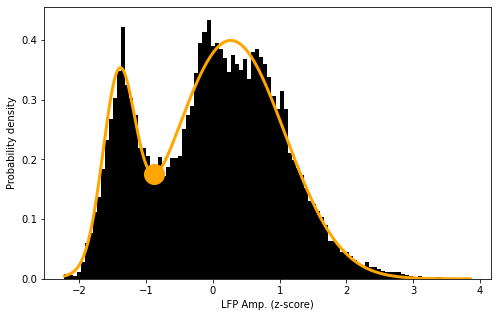

In [6]:
#get the histogram of the aggregate hippocampal LFP signal
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Get the histogram values and bin edges
hist_values, bin_edges, _ = ax.hist(aggregate_hpc_lfp, bins=100, density=True, color='k')

#fitting an bimodal distribution to the histogram
# Define the function to fit
def bimodal(x, mu1, sigma1, mu2, sigma2, p):
    return p * norm.pdf(x, mu1, sigma1) + (1 - p) * norm.pdf(x, mu2, sigma2)

# Fit the data using scipy.optimize.curve_fit
p0 = [0, 1, 0, 1, 0.5]
params, _ = curve_fit(bimodal, bin_edges[:-1], hist_values, p0=p0)

# Plot the fitted curve on top of the histogram
x = np.linspace(bin_edges[0], bin_edges[-1], 1000)
ax.plot(x, bimodal(x, *params), 'orange', linewidth=3)

#find the local minima of the fitted curve
local_minima = argrelextrema(bimodal(x, *params), np.less)[0]
#add the local minima to the plot
ax.plot(x[local_minima], bimodal(x, *params)[local_minima], 'o', color='orange', markersize=20)
    
SIA_threshold = x[local_minima][0]    
    
ax.set_xlabel('LFP Amp. (z-score)')
ax.set_ylabel('Probability density')

In [7]:
#get nonREM_interval from lowspeed_intervals, which equals to is_lowspeed = True and is_REM = False
is_nonREM = np.logical_and(is_lowspeed, np.logical_not(is_REM)) 

intervals = find_ones_intervals(is_nonREM)
nonREM_intervals = []
for interval in intervals:
    #store valid durations if it is more than duration seconds
    nonREM_intervals.append([is_nonREM.index[interval[0]], is_nonREM.index[interval[1]]])

#get SIA intervals
is_SIA, SIA_durations, SIA_intervals  = find_SIA_intervals(aggregate_hpc_lfp, SIA_threshold=SIA_threshold)
#print mean and std, and median of SIA durations in one line
print('SIA durations: mean = {:.2f} s, std = {:.2f} s, median = {:.2f} s'.format(np.mean(SIA_durations), np.std(SIA_durations), np.median(SIA_durations)))

#get LIA intervals as the intervals with is_lowspeed = True and is_REM = False and is_SIA = False
is_LIA = np.logical_and(is_lowspeed, np.logical_not(is_REM))
is_LIA = np.logical_and(is_LIA, np.logical_not(is_SIA))

LIA_int = find_ones_intervals(is_LIA)
LIA_intervals = []
for interval in LIA_int:
    #store valid durations if it is more than duration seconds
    LIA_intervals.append([is_LIA.index[interval[0]], is_LIA.index[interval[1]]])
    


SIA durations: mean = 4.19 s, std = 5.21 s, median = 1.94 s


In [14]:
#get the final sleep intervals

#for each nonREM_interval, if inside the interval, the length of LIA interval is more than 5 seconds, then keep this REM interval
#otherwise, set is_sleep_flags to False for that interval

#copy is_nonREM to is_sleep_flags
is_sleep_flags = is_nonREM.copy()
for nonREM_interval in nonREM_intervals:
    
    nonREM_duration = (nonREM_interval[1] - nonREM_interval[0]) / np.timedelta64(1, "s")
    print(nonREM_duration)
    
    if nonREM_duration < 90:
        #set is_sleep_flags to False for that interval
        is_sleep_flags.loc[nonREM_interval[0]:nonREM_interval[1]] = False
    else:
        #check if LIA duration is more than 5 seconds in this nonREM interval
        flag = False
        for LIA_interval in LIA_intervals:
            duration =  (LIA_interval[1] - LIA_interval[0]) / np.timedelta64(1, "s")
            #if the LIA interval is within any of the nonREM_intervals and the duration is more than 5 seconds, then keep it
            if (LIA_interval[0] >= nonREM_interval[0]) and (LIA_interval[1] <= nonREM_interval[1]) and (duration > 5):
                flag = True
                break
        if flag == False:
            #set is_sleep_flags to False for that interval
            is_sleep_flags.loc[nonREM_interval[0]:nonREM_interval[1]] = False

#get the sleep intervals
sleep_int = find_ones_intervals(is_sleep_flags)
sleep_intervals = []
for interval in sleep_int:
    #store valid durations if it is more than duration seconds
    sleep_intervals.append([is_sleep_flags.index[interval[0]], is_sleep_flags.index[interval[1]]])

20.376
73.986
213.522
2.088
81.2
57.148
18.49
217.592
0.49


### Plot the results

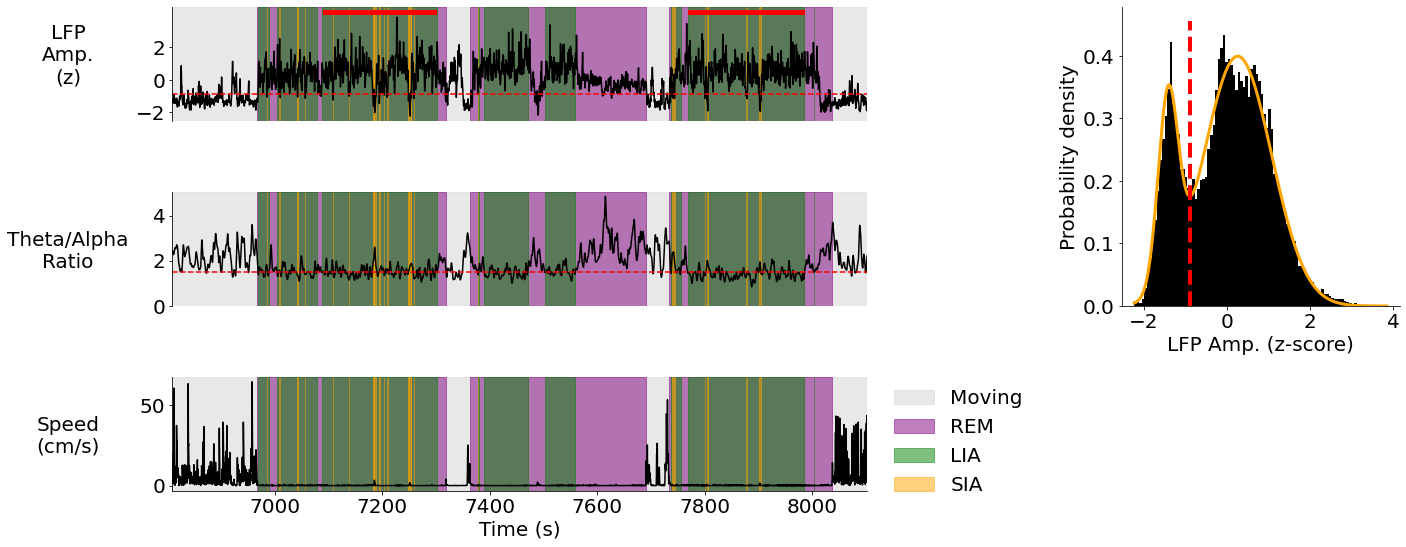

In [45]:
fig = plt.figure(figsize=(20, 8), facecolor='white') 

#make subplots height as 1:1:1:3
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[2.5, 1])

#set label font size
plt.rcParams.update({'font.size': 20})

#1, plot the aggregate hippocampal LFP signal
ax0 = plt.subplot(gs[0, 0])
ax0.plot(aggregate_hpc_lfp.index/np.timedelta64(1, "s"), aggregate_hpc_lfp, 'k', alpha=1)
#add SIAThreshold as a horizontal line
ax0.axhline(y=SIA_threshold, color='r', linestyle='--', label='SIA threshold')

ax0.set_ylabel('LFP\nAmp.\n(z)')
ax0.set_xticks([]); ax0.set_yticks([-2,0,2])
ax0.spines['bottom'].set_visible(False)

#2, plot the theta/alpha ratio
ax1 = plt.subplot(gs[1, 0])
ax1.plot(mean_theta2alpha_ratio.index/np.timedelta64(1, "s"), mean_theta2alpha_ratio, 'k', alpha=1)
ax1.set_ylabel('Theta/Alpha\nRatio')
#add REMthreshold as a horizontal line
ax1.axhline(y=REMthreshold, color='r', linestyle='--', label='REM threshold')

ax1.set_xticks([]); ax1.set_yticks([0,2,4])
ax1.spines['bottom'].set_visible(False)

#3, plot the speed
ax2 = plt.subplot(gs[2, 0])
ax2.plot(speed.index/np.timedelta64(1, "s"), speed, 'k', alpha=1)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Speed\n(cm/s)')   

#4 add shaded area for different sleep stages to all
times = aggregate_hpc_lfp.index/np.timedelta64(1, "s")
for ax in [ax0, ax1, ax2]:
    ax.set_xlim([times[0], times[-1]])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #set y label horizontal direction
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_horizontalalignment('center')
    #move the y label to the left
    ax.yaxis.set_label_coords(-0.15,0.3)
    
    #a, background color
    ax.axvspan(times[0], times[-1], alpha=0.5, color='lightgrey', label='Moving')
    
    #b, lowspeed sleep candidate as purple
    for i in range(len(lowspeed_intervals)):
        ax.axvspan(lowspeed_intervals[i][0]/np.timedelta64(1, "s"), lowspeed_intervals[i][1]/np.timedelta64(1, "s"), alpha=0.5, color='purple', label='REM')
    
    #c, nonREM intervals as green
    for i in range(len(nonREM_intervals)):
        ax.axvspan(nonREM_intervals[i][0]/np.timedelta64(1, "s"), nonREM_intervals[i][1]/np.timedelta64(1, "s"), alpha=0.5, color='green', label='LIA')

    
    #d, SIA intervals as orange
    for i in range(len(SIA_intervals)):
        SIA_interval = SIA_intervals[i]
        #if the SIA interval is within any of the nonREM_intervals, the plot it as orange
        for j in range(len(nonREM_intervals)):
            nonREM_interval = nonREM_intervals[j]
            if (SIA_interval[0] >= nonREM_interval[0]) and (SIA_interval[1] <= nonREM_interval[1]):
                ax.axvspan(SIA_interval[0]/np.timedelta64(1, "s"), SIA_interval[1]/np.timedelta64(1, "s"), alpha=0.5, color='orange', label='SIA')
                break

    #show the legend but without repeating the labels, put the legend outside the plot on the right side
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', bbox_to_anchor=(1.25, 1.05), frameon=False)

#e, add sleep_interval as thin black bars above axvspan (not overlapping with axvspan) at 1.1*ylim upper limit to the first plot
#get y lim for the first plot
y_upperlim = ax0.get_ylim()[1]
for i in range(len(sleep_intervals)):
    sleep_interval = sleep_intervals[i]
    ax0.plot([sleep_interval[0]/np.timedelta64(1, "s")+5, sleep_interval[1]/np.timedelta64(1, "s")-5], [y_upperlim, y_upperlim], 'r', alpha=1, linewidth=5)

#5, plot the histogram of the aggregate hippocampal LFP signal by merging gs[0,1] and gs[1,1]

ax3 = plt.subplot(gs[0:2, 1])
# Get the histogram values and bin edges
hist_values, bin_edges, _ = ax3.hist(aggregate_hpc_lfp, bins=100, density=True, color='k')

#fitting an bimodal distribution to the histogram
# Define the function to fit
def bimodal(x, mu1, sigma1, mu2, sigma2, p):
    return p * norm.pdf(x, mu1, sigma1) + (1 - p) * norm.pdf(x, mu2, sigma2)

# Fit the data using scipy.optimize.curve_fit
p0 = [0, 1, 0, 1, 0.5]
params, _ = curve_fit(bimodal, bin_edges[:-1], hist_values, p0=p0)

# Plot the fitted curve on top of the histogram
x = np.linspace(bin_edges[0], bin_edges[-1], 1000)
ax3.plot(x, bimodal(x, *params), 'orange', linewidth=3)

#find the local minima of the fitted curve
local_minima = argrelextrema(bimodal(x, *params), np.less)[0]
#add vertical lines for the local minima of y lim 
#get y lim

ax3.plot([x[local_minima][0], x[local_minima][0]], ax3.get_ylim(), 'r--', alpha=1, linewidth=4)
    
SIA_threshold = x[local_minima][0]    
    
ax3.set_xlabel('LFP Amp. (z-score)')
ax3.set_ylabel('Probability density')
#up and right spines are not visible
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()
